In [26]:
#To run in Jupyter Notebook:
%run reading_3sat 
%run read_histogram

#Imports
from reading_3sat import *
from qiskit import QuantumRegister, ClassicalRegister
import math
from qiskit.circuit.library import MCMT
from qiskit.circuit.library.standard_gates import *
from qiskit import QuantumCircuit, execute, Aer
from qiskit.tools.monitor import job_monitor
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.circuit.library import QFT

pi = np.pi

In [30]:
def OR_gates(circuit, clauses):
    for clause in clauses:
        input_qubits = []  #Create a list of qubits for the mct gate 
        clause_num = clauses.index(clause) #Save the index of this clause as "clause_num"  
                                            #(=the qubit used for this OR gate result)
        
        for c in clause:
            #Add a NOT gate for each variable with no ¬ and add the variable in 'input_qubits'
            if "¬" not in c:
                variable_num = variables.index(c) #This is the index of the qubit that represents this variable
                                                        
                input_qubits.append(variable_num)
                circuit.x(variable_num)
            else:
                variable_num = variables.index(c[1:]) #The index is used to not include the negation symbol
                input_qubits.append(variable_num)
        
        #Add a NOT gate before applying a multi-controlled toffoli gate, to simulate an OR gate
        circuit.x(len(variables) + clause_num)
        circuit.mct(input_qubits, len(variables) + clause_num)

        for c in clause:
            #Add another NOT for each variable with no ¬
            if "¬" not in c:
                variable_num = variables.index(c) 
                circuit.x(variable_num)   
    return

def oracle(n, print_flag = 0):
    qc = QuantumCircuit(n)
    
    #Create the OR gates
    OR_gates(qc, clauses)

    #Multiply the OR-gate(s) results; control qubit becomes 1 when all of them are 1
    and_inputs = []
    for i in range(len(variables)-ancilla_no, len(variables) + len(clauses)):
        and_inputs.append(i)
        
    if len(clauses):
        qc.mct(and_inputs, -1)
    else:
        qc.x(-1)

    #Mirroring
    OR_gates(qc, clauses)
    if print_flag==1:
        print(qc)
    return qc.to_gate(label=" Oracle ")

def diffuser(n, print_flag = 0):
    qc = QuantumCircuit(n)
    
    #Create a list of the qubits and initialize 
    var_qubits = []
    for i in range(n):
        var_qubits.append(i)
        qc.h(i)
        qc.x(i)
    
    #Simulate a multicontrolled Z-gate
    qc.h(var_qubits[-1])
    qc.mct(var_qubits[0:-1], var_qubits[-1])
    qc.h(var_qubits[-1])
    
    #NOT and HADAMARD gates to all qubits
    for i in range(n):
        qc.x(i)
        qc.h(i)
    if print_flag==1:
        print(qc)
    return qc.to_gate(label=" Diffuser ")

#-------------------------------------------------------------------------------------------------------------------------------

#CNF INPUT

cnf = "(¬x∨¬y∨¬z)∧(x∨y∨z)"
#cnf = input("CNF - e.g. (x∨y∨z)∧(¬x∨¬y∨z)∧(x∨¬y∨¬z): ") #Uncomment for user input
variables, clauses = array_from_cnf(cnf)   

print("Clauses:", clauses)
print("Order of variables:", variables) 
N = len(variables)
C = len(clauses)    
ancilla_no = 0

#----GROVER GATE CREATION----

#Initialization
q = QuantumRegister(N + C + 1,'q')     
grover_gate = QuantumCircuit(q)

#Oracle
grover_gate.append(oracle(N + C + 1), range(N + C + 1))

#Diffuser
grover_gate.append(diffuser(N), range(N))   

#Make custom gate
grover = grover_gate.to_gate(label = ' G ')


# ----QUANTUM PHASE ESTIMATION--------------------------------------------------------------------------------------------------
t = 6
qpe = QuantumCircuit(t + N + C + 1, t)    

# Prepare initial state
for i in range(t + N):
    qpe.h(i)
    
#Control qubit gets initialized
qpe.x(t + N + C)
qpe.h(t + N + C)

qpe.barrier()

# Controlled-U operations:
gate = grover.control()
gate.calibrations = qpe.calibrations
repetitions = 1
target = []
for i in range(t, t + N + C + 1):
    target.append(i)
for q in range(t):
    for i in range(repetitions):
        qpe.append(gate, [q] + target);
    repetitions *= 2

# Inverse QFT:
qpe = qpe.compose(QFT(t, inverse=True), range(t))

# Measurements
qpe.barrier()
qpe.measure(range(t),range(t)) 
    
#Run circuit
backend1 = Aer.get_backend('qasm_simulator')
counts = execute(qpe, backend1, shots=1024).result().get_counts()

#Estimate phase and number of solutions (m) 
reading = max(counts, key = lambda x: counts[x])
print("QPE reading:", reading)
phase = (int(reading, 2)/2**t)
theta = 2*pi*phase
m = (2**N)*((math.sin(theta/2))**2)
m = (2**N) - round(m)

print("Estimated phase:", phase)
print("Estimated solutions: %i out of %i" %(m, (2**N)))

iterations = 1
if m == 0:
    print("This 3_SAT input is estimated not to be satisfiable.")
elif m == 2**N:
    print("This 3_SAT input is estimated to always be satisfiable.")
elif m<2**N/2:
    iterations = math.floor((pi/4)*((2**N)/m)**0.5)
    print("Estimated iterations:", iterations)

#DOUBLING THE SEARCH SPACE
#Adding ancilla qubits when m is more than half the search space
else:
    if m>=2**N/2 and m<0.75*2**N:
        print("Adding an ancilla qubit")
        ancilla_no = 1
        for i in range(ancilla_no):
            variables.append('a' + str(i))

    if m>=0.75*2**N:
        print("Adding 2 ancilla qubits")
        ancilla_no = 2
        for i in range(ancilla_no):
            variables.append('a' + str(i))
    N = len(variables)
    C = len(clauses)    

    #NEW GROVER OPERATOR
    #Initialization
    q = QuantumRegister(N + C + 1,'q')     
    c = ClassicalRegister(N,'c')
    grover_gate = QuantumCircuit(q)

    #Oracle
    grover_gate.append(oracle(N + C + 1), range(N + C + 1))

    #Diffuser
    grover_gate.append(diffuser(N), range(N))   

    #Add control
    grover = grover_gate.to_gate(label = ' G ')

    #New iterations
    iterations = math.floor((pi/4)*((2**N)/m)**0.5)
    print("Estimated iterations:", iterations)

#-------------------------------------------------------------------------------------------------------------------------------
#----GROVER----    

#INITIALIZATION 
q = QuantumRegister(N + C + 1,'q') 
c = ClassicalRegister(N - ancilla_no,'c')
circuit = QuantumCircuit(q,c)

#All input qubits get initialized with a Hadamard gate                         
i=0
while (i<N):
    circuit.h(q[i])
    i+=1
    
#Control qubit gets initialized
circuit.x(q[-1])
circuit.h(q[-1])

circuit.barrier()

#ITERATIONS
#After the initialization circuit, the main circuit is repeated as many times as needed
print("Oracle and grover operator will be repeated", iterations, "time(s)")

#Adding one combination of O-G for each iteration
for i in range(iterations):
    circuit.append(grover, range(N + C + 1))
    
#MEASUREMENTS
for i in range(0, N - ancilla_no):
    circuit.measure(q[i], N - ancilla_no - 1 - i)

Clauses: [['¬x', '¬y', '¬z'], ['x', 'y', 'z']]
Order of variables: ['x', 'y', 'z']
QPE reading: 110101
Estimated phase: 0.828125
Estimated solutions: 6 out of 8
Adding 2 ancilla qubits
Estimated iterations: 1
Oracle and grover operator will be repeated 1 time(s)


Job Status: job has successfully run
{'011': 312, '110': 360, '010': 346, '100': 343, '101': 315, '001': 342, '000': 16, '111': 14}
Frequent values in histogram: ['011', '110', '010', '100', '101', '001']
***This 3-SAT input is satisfiable.***
Values that satisfy it are: ['x', 'y', 'z'] = ['011', '110', '010', '100', '101', '001']


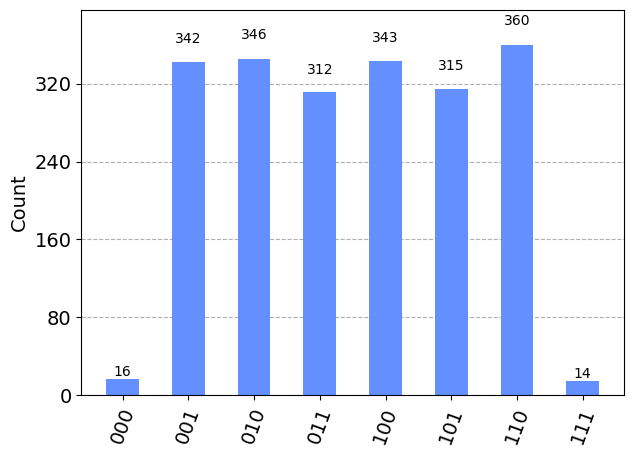

In [31]:
backend1 = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend1, shots=2048)
job_monitor(job)

counts = job.result().get_counts()

print(counts)
read_data(counts, clauses, variables[:N - ancilla_no])
plot_histogram(counts)

C:\Users\anthi\anaconda3\lib\site-packages\qiskit_ibm_provider\ibm_backend.py:445: UserWarning: The backend ibmq_jakarta is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


Job Status: job has successfully run
All values in histogram are about equal
***This 3-SAT input is not satisfiable.***


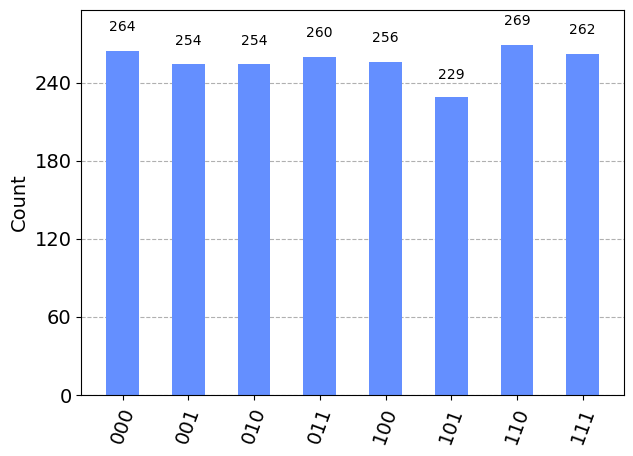

In [24]:
#For running on IBM
%run ibm_connection.py

backend = "ibmq_qasm_simulator"
backend = "ibmq_jakarta" #Uncomment to run on ibmq_jakarta, if circuit size allows it
counts = run(circuit, backend)
read_data(counts, clauses, variables[:N - ancilla_no])
plot_histogram(counts)